In [ ]:
import os
import torch
from torch import nn
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [ ]:
num_to_letter = {
    "0": "A",
    "1": "B",
    "2": "C",
    "3": "D",
    "4": "E",
    "5": "F",
    "6": "G",
    "7": "H",
    "8": "I",
    "9": "K",
    "10": "L",
    "11": "M",
    "12": "N",
    "13": "O",
    "14": "P",
    "15": "Q",
    "16": "R",
    "17": "S",
    "18": "T",
    "19": "U",
    "20": "V",
    "21": "W",
    "22": "X",
    "23": "Y",
    "24": "Z"
}

In [ ]:
!pip install --upgrade kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.9
    Uninstalling kagglehub-0.3.9:
      Successfully uninstalled kagglehub-0.3.9


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datamunge/sign-language-mnist") # You may ignore the error regarding the KaggleHub version if it shows

print("Path to dataset files:", path)

100%|██████████| 62.6M/62.6M [00:00<00:00, 66.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/datamunge/sign-language-mnist/versions/1


In [ ]:
print(os.listdir(path))

['american_sign_language.PNG', 'sign_mnist_train', 'sign_mnist_test', 'sign_mnist_train.csv', 'amer_sign3.png', 'amer_sign2.png', 'sign_mnist_test.csv']


In [ ]:
train_dir = os.path.join(path, "sign_mnist_train.csv")
test_dir = os.path.join(path, "sign_mnist_test.csv")

In [ ]:
train_df=pd.read_csv(train_dir)
test_df=pd.read_csv(test_dir)

train_images=train_df.drop('label',axis=1).values.reshape((-1,28,28,1))
train_labels=train_df['label'].values

test_images=test_df.drop('label',axis=1).values.reshape((-1,28,28,1))
test_labels=test_df['label'].values

In [ ]:
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


In [ ]:
image_num = 9234 #@param {type:"raw"}

In [ ]:
print(train_images[image_num].shape)

(28, 28, 1)


Text(0.5, 1.0, 'A')

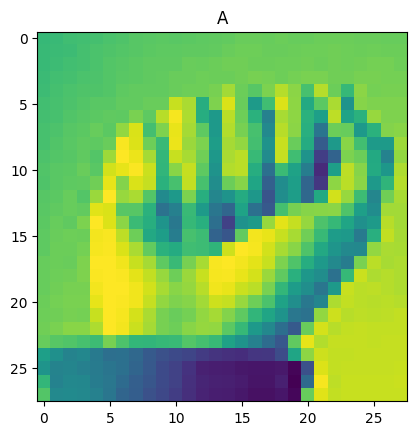

In [ ]:
plt.imshow(train_images[image_num])
plt.title(num_to_letter[f"{train_labels[image_num]}"])

In [ ]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_layer=784, output=25):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_layer, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output),

    )
  def forward(self, x):
    return self.layers(x)

model = MLP()

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 25]           3,225
Total params: 569,369
Trainable params: 569,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.17
Estimated Total Size (MB): 2.19
----------------------------------------------------------------


In [ ]:
train_images = torch.tensor(train_images)
train_labels = torch.tensor(train_labels)
train_images = train_images.permute(0, 3, 1, 2) # Change form (Batch, Height, Width, Channel) to (B, C, H, W)

test_images = torch.tensor(test_images)
test_labels = torch.tensor(test_labels)
test_images = test_images.permute(0, 3, 1, 2) # Change form (Batch, Height, Width, Channel) to (B, C, H, W)

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([27455, 1, 28, 28])
torch.Size([27455])
torch.Size([7172, 1, 28, 28])
torch.Size([7172])


In [ ]:
train_set = TensorDataset(train_images, train_labels)
test_set = TensorDataset(test_images, test_labels)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def trainer(model, train_loader, loss_fn, optimizer, epochs):
  model.train()
  train_losses = []
  for epoch in range(epochs):
    train_loss_epoch = 0
    for image, label in tqdm(train_loader, desc="Training Model"):
      image = image.to(torch.float32)
      label = label.to(torch.int64)

      optimizer.zero_grad()

      pred = model(image)
      loss = loss_fn(pred, label)
      loss.backward()
      train_loss_epoch += loss.item()

      optimizer.step()

    avg_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_loss)

    print(f'Epoch: {epoch+1} | Loss: {avg_loss:.4f}')

  return train_losses

In [ ]:
losses = trainer(model, train_loader, loss_fn, optimizer, epochs=20)

Training Model: 100%|██████████| 858/858 [00:10<00:00, 84.09it/s]


Epoch: 1 | Loss: 2.3258


Training Model: 100%|██████████| 858/858 [00:15<00:00, 56.04it/s]


Epoch: 2 | Loss: 0.8496


Training Model: 100%|██████████| 858/858 [00:15<00:00, 55.06it/s]


Epoch: 3 | Loss: 0.5354


Training Model: 100%|██████████| 858/858 [00:15<00:00, 56.19it/s]


Epoch: 4 | Loss: 0.4101


Training Model: 100%|██████████| 858/858 [00:15<00:00, 57.11it/s]


Epoch: 5 | Loss: 0.2976


Training Model: 100%|██████████| 858/858 [00:15<00:00, 56.41it/s]


Epoch: 6 | Loss: 0.3132


Training Model: 100%|██████████| 858/858 [00:16<00:00, 53.20it/s]


Epoch: 7 | Loss: 0.2570


Training Model: 100%|██████████| 858/858 [00:15<00:00, 54.16it/s]


Epoch: 8 | Loss: 0.2655


Training Model: 100%|██████████| 858/858 [00:15<00:00, 55.84it/s]


Epoch: 9 | Loss: 0.1970


Training Model: 100%|██████████| 858/858 [00:14<00:00, 57.32it/s]


Epoch: 10 | Loss: 0.2931


Training Model: 100%|██████████| 858/858 [00:15<00:00, 54.07it/s]


Epoch: 11 | Loss: 0.2156


Training Model: 100%|██████████| 858/858 [00:15<00:00, 54.48it/s]


Epoch: 12 | Loss: 0.1779


Training Model: 100%|██████████| 858/858 [00:15<00:00, 55.60it/s]


Epoch: 13 | Loss: 0.2473


Training Model: 100%|██████████| 858/858 [00:15<00:00, 55.87it/s]


Epoch: 14 | Loss: 0.0416


Training Model: 100%|██████████| 858/858 [00:15<00:00, 53.96it/s]


Epoch: 15 | Loss: 0.0007


Training Model: 100%|██████████| 858/858 [00:15<00:00, 54.76it/s]


Epoch: 16 | Loss: 0.0003


Training Model: 100%|██████████| 858/858 [00:16<00:00, 52.72it/s]


Epoch: 17 | Loss: 0.0002


Training Model: 100%|██████████| 858/858 [00:15<00:00, 54.98it/s]


Epoch: 18 | Loss: 1.2397


Training Model: 100%|██████████| 858/858 [00:15<00:00, 54.70it/s]


Epoch: 19 | Loss: 3.1859


Training Model: 100%|██████████| 858/858 [00:16<00:00, 53.38it/s]

Epoch: 20 | Loss: 3.1805


In [ ]:
print(losses)

[2.325834977599013, 0.8496253896322283, 0.5353513480900051, 0.4101480038875675, 0.2976411725687501, 0.3132250115377416, 0.2570424070305002, 0.26547821133836047, 0.19702977645371028, 0.29309754841106167, 0.2156277468106381, 0.17785143544330287, 0.24732811104002603, 0.041623192529443305, 0.0006772311946431702, 0.00031091635125739546, 0.00016986949774989432, 1.2397397247022983, 3.1859446105423506, 3.180540175148935]


In [ ]:
epochs = list(range(1, 11)) # Replace 6 with however many eopchs you have above plus 1

In [ ]:
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

In [ ]:
def accuracy(correct, total):
  return (correct / total) * 100

In [ ]:
def tester(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for image, label in tqdm(test_loader, desc="Testing Model"):
      image = image.to(torch.float32)
      label = label.to(torch.int64)

      pred = model(image) # Remember it returns probabilities of what everything could be

      predicted_classes = pred.argmax(dim=1)

      batch_correct = (predicted_classes == label).sum().item()
      correct += batch_correct

    print(f"Correct: {correct} | Total: {len(test_loader)*32}")

  acc = accuracy(correct, len(test_loader)*32)

  return acc

In [ ]:
tester(model, test_loader)

In [ ]:
image = 100
plt.imshow(test_images[image].permute(1, 2, 0))

In [ ]:
with torch.no_grad():
  pred = model(test_images[image].to(torch.float32).unsqueeze(0)) # Add a dimension for batch
  print(num_to_letter[f"{pred.argmax(1).item()}"])